In [1]:
import errno
import json
import os
from glob import glob
import cv2
import pandas as pd 
import scipy.misc
from scipy.ndimage import rotate
from scipy.stats import bernoulli
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
dataDIR = 'data'
logFile = os.path.join(dataDIR, 'driving_log.csv')
raw_data = pd.read_csv(logFile)
raw_data.head()

,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


In [3]:
print('Number of images per camera in the log file: {}'.format(
                                                    raw_data.shape[0]))

Number of images per camera in the log file: 8036


In [4]:
raw_data['steering'].describe()

count    8036.000000
mean        0.004070
std         0.128840
min        -0.942695
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: steering, dtype: float64

The data is skewed towards small steering angles. Below is the histogram on linear scale and log scale to confirm this observation.

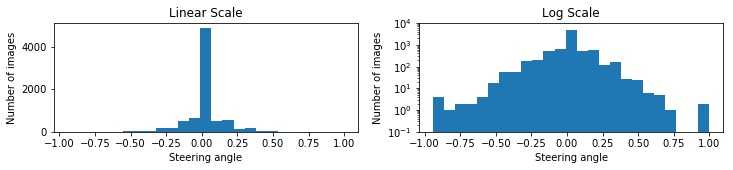

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12, 2))
for ax in axes:
    ax.hist(raw_data['steering'], bins=25)
    ax.set_xlabel('Steering angle')
    ax.set_ylabel('Number of images')
    
axes[1].set_ylim([0.1, 10000])
axes[1].set_yscale('log')
axes[1].set_title('Log Scale')
axes[0].set_title('Linear Scale')
plt.show()

Data visualization
========================

## Helper function to display three random images for each of the three camera angles

In [6]:
number_of_images = len(raw_data['center'])
number_of_images

8036

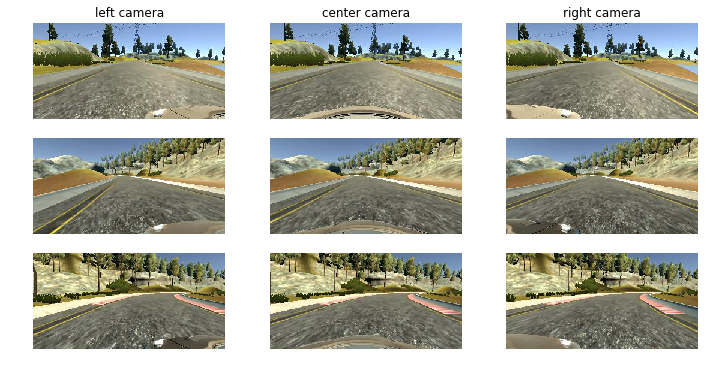

In [7]:
number_of_images = len(raw_data['center'])
camera_positions = ['left','center','right']

class generate_image :
    def __init__(self, img_index, camera_position='center') :
        self.img_data = raw_data.iloc[img_index]
        self.steer = self.img_data['steering']
        file_name = os.path.join(dataDIR,self.img_data[camera_position].strip())
        img = cv2.imread(file_name)
        self.image = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)


# display random images for different camera angles
fig, axes = plt.subplots(3, 3, figsize=(12,6))
for pos,ax in zip(camera_positions, axes[0,:]):
    ax.set_title(pos+' camera')
for ax in axes :
    img_index = random.randrange(number_of_images)
    for a, pos in zip(ax, camera_positions) :
        img = generate_image(img_index, camera_position=pos)
        a.imshow(img.image)
        a.axis('off')

Data Preprocessing
=========================

For Image preprocessing, we apply the following steps:
- **Crop image**: crop the top by 35% to remove things above horizon(such as sky etc) and the bottom by 10% in order to remove the car hood.

- ** Resize image**: All images are resized to 64x64 pixels

- ** Random gamma** correction is used as an alternative method changing    the brightness of training images.



In [8]:
# Some useful constants
DRIVING_LOG_FILE = './data/driving_log.csv'
IMG_PATH = './data/'
STEERING_COEFFICIENT = 0.229


In [9]:

def crop(image, top_percent=0.35, bottom_percent=0.1):
    """
    Crops an image according to the given parameters
    Args:
     - image: 
        source image
     - top_percent:
        The percentage of the original image will be cropped from the top of the image
     - bottom_percent:
        The percentage of the original image will be cropped from the bottom of the image
     Return:
      - The cropped image
    """
    assert 0 <= top_percent < 0.5, 'top_percent should be between 0.0 and 0.5'
    assert 0 <= bottom_percent < 0.5, 'top_percent should be between 0.0 and 0.5'

    top = int(np.ceil(image.shape[0] * top_percent))
    bottom = image.shape[0] - int(np.ceil(image.shape[0] * bottom_percent))

    return image[top:bottom, :]


def resize(image, new_dim=(64, 64)):
    """
    Resize a given image according the the new dimension
    Args:
    - image:
        Source image
    - new_dim:
        A tuple which represents the resize dimension
    Return:
        Resized image
    """
    return scipy.misc.imresize(image, new_dim)


def random_gamma(image):
    """
    Random gamma correction is used as an alternative method changing the brightness of
    training images.
    http://www.pyimagesearch.com/2015/10/05/opencv-gamma-correction/
    Args:
     - image:
        Source image
    Return:
      - New image generated by applying gamma correction to the source image
    """
    gamma = np.random.uniform(0.4, 1.5)
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255
                      for i in np.arange(0, 256)]).astype("uint8")

    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)


def preprocess(img, new_dim = (64, 64)):
    new_img = crop(img)
    new_img = random_gamma(new_img)
    return resize(new_img)


Image Preprocessing Pipeline in action
======================================

In [10]:
def display_preprocess_pipeline(images) :
    """
    Displays preprocessing pipeline for list of images
    """
    nrows = len(images)
    fig, axes = plt.subplots(nrows, 4, figsize=(15,2*nrows))
    
    # pre-processing pipeline
    pipeline = ['Original','Crop','Random Gamma ','Resize']
    
    # plot pipeline
    for ax, p in zip(axes[0,:], pipeline) :
        ax.set_title(p)
    for ax,img in zip(axes,images) :
        ax[0].imshow(img)
        img = crop(img)
        ax[1].imshow(img)
        img = random_gamma(img)
        ax[2].imshow(img)
        img = resize(img)
        ax[3].imshow(img)
        for a in ax :
            a.axis('off')

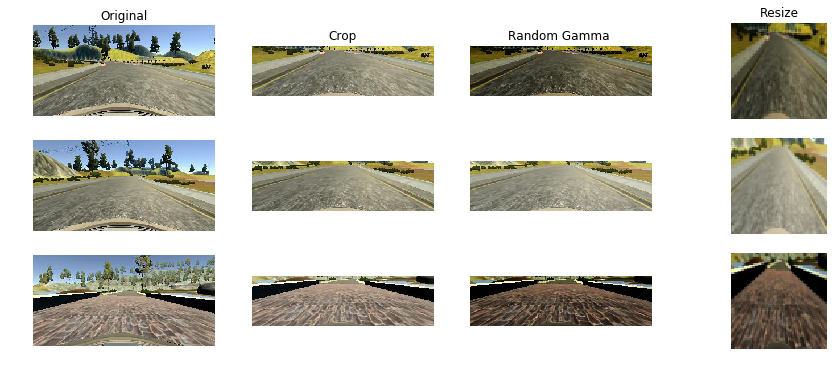

In [11]:
img_list = [generate_image(random.randrange(number_of_images)).image for i in range(3)]
display_preprocess_pipeline(img_list)

Image Augmentation
=========================

The following image augmentations are performed real time during training :

- ** Random Flip** : Images are flipped about vertical axis and the sign of steering sign is changed. This leads to better generalization for new datasets.
- **Random Shear** 

- **Random Rotation**

In [12]:

def random_flip(image, steering_angle, flipping_prob=0.5):
    """
    Based on the outcome of an coin flip, the image will be flipped.
    If flipping is applied, the steering angle will be negated.
    Args:
     - image: 
        Source image
     - steering_angle: 
        Original steering angle
    Return: 
        - Both flipped image and new steering angle
    """
    head = bernoulli.rvs(flipping_prob)
    if head:
        return np.fliplr(image), -1 * steering_angle
    else:
        return image, steering_angle





def random_shear(image, steering_angle, shear_range=200):
    """
    Source: https://medium.com/@ksakmann/behavioral-cloning-make-a-car-drive-like-yourself-dc6021152713#.7k8vfppvk
    Args:
     - image:
        Source image on which the shear operation will be applied
     - steering_angle:
        The steering angle of the image
     - shear_range:
        Random shear between [-shear_range, shear_range + 1] will be applied
    Return:
        The image generated by applying random shear on the source image
    """
    rows, cols, ch = image.shape
    dx = np.random.randint(-shear_range, shear_range + 1)
    random_point = [cols / 2 + dx, rows / 2]
    pts1 = np.float32([[0, rows], [cols, rows], [cols / 2, rows / 2]])
    pts2 = np.float32([[0, rows], [cols, rows], random_point])
    dsteering = dx / (rows / 2) * 360 / (2 * np.pi * 25.0) / 6.0
    M = cv2.getAffineTransform(pts1, pts2)
    image = cv2.warpAffine(image, M, (cols, rows), borderMode=1)
    steering_angle += dsteering

    return image, steering_angle


def random_rotation(image, steering_angle, rotation_amount=15):
    """
    Args:
        - image:
        - steering_angle:
        - rotation_amount:
    Return:
        - Randomly rotated image and steering_angle
    """
    angle = np.random.uniform(-rotation_amount, rotation_amount + 1)
    rad = (np.pi / 180.0) * angle
    return rotate(image, angle, reshape=False), steering_angle + (-1) * rad


def min_max(data, a=-0.5, b=0.5):
    """
    Args:
    - data:
    - a:
    - b:
    Return:
    """
    data_max = np.max(data)
    data_min = np.min(data)
    return a + (b - a) * ((data - data_min) / (data_max - data_min))



In [13]:
def generate_new_image(image, steering_angle, top_crop_percent=0.35, bottom_crop_percent=0.1,
                       resize_dim=(64, 64), do_shear_prob=0.9):
    """
    Args:
    - image:
    - steering_angle:
    - top_crop_percent:
    - bottom_crop_percent:
    - resize_dim:
    - do_shear_prob:
    - shear_range:
    Return:
    """
    head = bernoulli.rvs(do_shear_prob)
    if head == 1:
        image, steering_angle = random_shear(image, steering_angle)

    image = crop(image, top_crop_percent, bottom_crop_percent)

    image, steering_angle = random_flip(image, steering_angle)

    image = random_gamma(image)

    image = resize(image, resize_dim)

    return image, steering_angle


def get_next_image_files(batch_size=64):
    """
    The simulator records three images (namely: left, center, and right) at a given time
    However, when we are picking images for training we randomly (with equal probability)
    one of these three images and its steering angle.
    Args:
    - batch_size:
        Size of the image batch
    Return:
        An list of selected (image files names, respective steering angles)
    """
    data = pd.read_csv(DRIVING_LOG_FILE)
    num_of_img = len(data)
    rnd_indices = np.random.randint(0, num_of_img, batch_size)

    image_files_and_angles = []
    for index in rnd_indices:
        rnd_image = np.random.randint(0, 3)
        if rnd_image == 0:
            img = data.iloc[index]['left'].strip()
            angle = data.iloc[index]['steering'] + STEERING_COEFFICIENT
            image_files_and_angles.append((img, angle))

        elif rnd_image == 1:
            img = data.iloc[index]['center'].strip()
            angle = data.iloc[index]['steering']
            image_files_and_angles.append((img, angle))
        else:
            img = data.iloc[index]['right'].strip()
            angle = data.iloc[index]['steering'] - STEERING_COEFFICIENT
            image_files_and_angles.append((img, angle))

    return image_files_and_angles



In [14]:
def display_augment_pipeline(images) :
    """
    Displays Image augmentation pipeline for list of images
    """
    nrows = len(images)
    fig, axes = plt.subplots(nrows, 4, figsize=(15,2*nrows))
    
    # Image Augmentation pipeline
    pipeline = ['Original','random Flip','Random Shear','Random Rotation']
    
    # plot pipeline
    for ax, p in zip(axes[0,:], pipeline) :
        ax.set_title(p)
    for ax,img in zip(axes,images) :
        image = plt.imread(IMG_PATH + img[0])
        steer = img[1]
        
        ax[0].imshow(image)
        new_image, new_steer = random_flip(image, steer)
        ax[1].imshow(new_image)
        new_image, new_steer = random_shear(image, steer)
        ax[2].imshow(new_image)
        new_image, new_steer = random_rotation(image, steer)
        ax[3].imshow(new_image )
        for a in ax :
            a.axis('off')

Visualize each of the data augmentation operation
=================================================

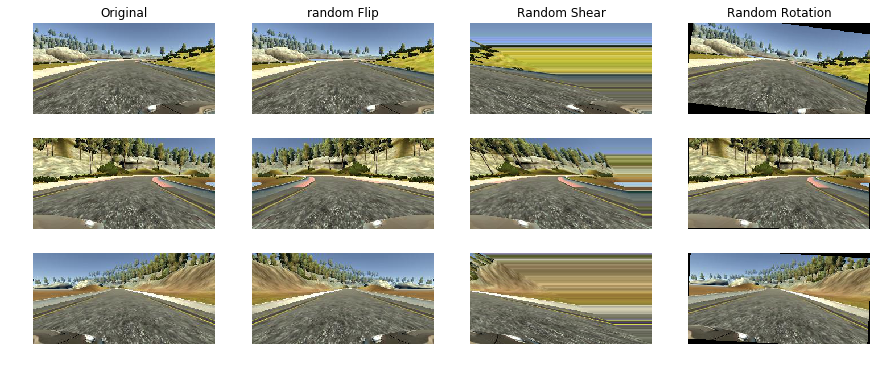

In [15]:
images = get_next_image_files(batch_size=3)
display_augment_pipeline(images)

In [16]:

def generate_next_batch(batch_size=64):
    """
    This generator yields the next training batch
    Args:
    - batch_size:
        Number of training images in a single batch
    Return:
        A tuple of features and steering angles as two numpy arrays
    """
    while True:
        X_batch = []
        y_batch = []
        images = get_next_image_files(batch_size)
        for img_file, angle in images:
            raw_image = plt.imread(IMG_PATH + img_file)
            raw_angle = angle
            new_image, new_angle = generate_new_image(raw_image, raw_angle)
            X_batch.append(new_image)
            y_batch.append(new_angle)

        assert len(X_batch) == batch_size, 'len(X_batch) == batch_size should be True'

        yield np.array(X_batch), np.array(y_batch)


def save_model(model, model_name='model.json', weights_name='model.h5'):
    """
    Save the model into the hard disk
    Args:
    - model:
        Keras model to be saved
    - model_name:
        The name of the model file
    - weights_name:
        The name of the weight file
    Return:
        None
    """
    silent_delete(model_name)
    silent_delete(weights_name)

    json_string = model.to_json()
    with open(model_name, 'w') as outfile:
        json.dump(json_string, outfile)

    model.save_weights(weights_name)


1. Model Architecture
=======================================

This architecture resembles NVIDIA architecture for the convolutional layers. 
_____________________________

<img src="model.jpg" width="400" height="70">

In [17]:

import tensorflow as tf
from keras.layers import Dense, Flatten, Lambda, Activation, MaxPooling2D
from keras.layers.convolutional import Convolution2D
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import pickle

import preprocess

tf.python.control_flow_ops = tf

number_of_epochs = 8
number_of_samples_per_epoch = 20032
number_of_validation_samples = 6400
learning_rate = 1e-4
activation_relu = 'relu'

# The model is based on NVIDIA's "End to End Learning for Self-Driving Cars" paper
# Source:  https://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf
model = Sequential()

model.add(Lambda(lambda x: x / 127.5 - 1.0, input_shape=(64, 64, 3)))

# Five convolutional and maxpooling layers
model.add(Convolution2D(24, 5, 5, border_mode='same', subsample=(2, 2)))
model.add(Activation(activation_relu))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

model.add(Convolution2D(36, 5, 5, border_mode='same', subsample=(2, 2)))
model.add(Activation(activation_relu))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

model.add(Convolution2D(48, 5, 5, border_mode='same', subsample=(2, 2)))
model.add(Activation(activation_relu))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

model.add(Convolution2D(64, 3, 3, border_mode='same', subsample=(1, 1)))
model.add(Activation(activation_relu))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

model.add(Convolution2D(64, 3, 3, border_mode='same', subsample=(1, 1)))
model.add(Activation(activation_relu))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

model.add(Flatten())

# Five fully connected layers
model.add(Dense(1164))
model.add(Activation(activation_relu))

model.add(Dense(100))
model.add(Activation(activation_relu))

model.add(Dense(50))
model.add(Activation(activation_relu))

model.add(Dense(10))
model.add(Activation(activation_relu))

model.add(Dense(1))

model.summary()

model.compile(optimizer=Adam(learning_rate), loss="mse", )

Using TensorFlow backend.


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 64, 64, 3)     0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 32, 32, 24)    1824        lambda_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 32, 32, 24)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 31, 31, 24)    0           activation_1[0][0]               
___________________________________________________________________________________________

In [18]:
# Save Model Architecture Visualization to disk 
from keras.utils.visualize_util import plot
plot(model, show_shapes=True, 
     to_file='model.jpg')

In [ ]:
# checkpoint
checkpoint = ModelCheckpoint("model-{epoch:02d}.h5", monitor='loss', verbose=1, save_best_only=False, mode='max')
callbacks_list = [checkpoint]

# create two generators for training and validation
train_gen = preprocess.generate_next_batch()
validation_gen = preprocess.generate_next_batch()

history = model.fit_generator(train_gen,
                              samples_per_epoch=number_of_samples_per_epoch,
                              nb_epoch=number_of_epochs,
                              validation_data=validation_gen,
                              nb_val_samples=number_of_validation_samples,
                              verbose=1,
                              callbacks=callbacks_list)

# finally save our model and weights
preprocess.save_model(model)

hist_history = history.history
pickle.dump(hist_history, open("hist_history.p", "wb"))

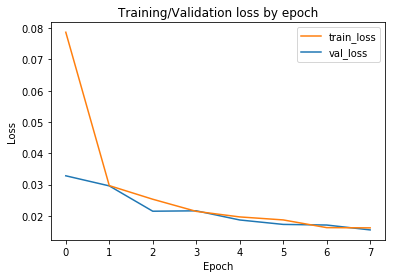

In [19]:
history_loss = pickle.load( open( "hist_history.p", "rb" ) )
ax = plt.subplot(1,1,1)
p1, = ax.plot(history_loss['val_loss'], label="val_loss")
p2, = ax.plot(history_loss['loss'], label="train_loss")

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1])
plt.title("Training/Validation loss by epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [20]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [21]:
model_prediction = 'Final_model_performance.mp4'
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(model_prediction))

Visualize the weights
===================

In [22]:
# utility functions
from mpl_toolkits.axes_grid1 import make_axes_locatable

def nice_imshow(ax, data, vmin=None, vmax=None, cmap=None):
    """Wrapper around pl.imshow"""
    if cmap is None:
        cmap = cm.jet
    if vmin is None:
        vmin = data.min()
    if vmax is None:
        vmax = data.max()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    im = ax.imshow(data, vmin=vmin, vmax=vmax, interpolation='nearest', cmap=cmap)
    pl.colorbar(im, cax=cax)

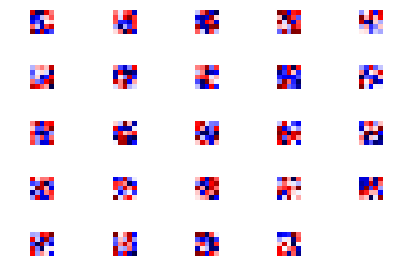

In [23]:
from keras import backend as K

original_w = K.get_value(model.layers[1].W)
weights_layer_1 = np.squeeze(original_w)

wmin = np.min(weights_layer_1)
wmax = np.max(weights_layer_1)

fig, axes = plt.subplots(5,5)

for i, ax in enumerate(axes.flat):
    if i < 24:
        image = weights_layer_1[:,:,:,i].reshape([5,5,3]) 
        image_g = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        ax.imshow(image_g, cmap='seismic') #,cmap = 'gray')
        #ax.imshow(image,vmin=wmin, vmax=wmax, cmap='seismic')
        ax.axis('off')

plt.axis('off')
plt.tight_layout()
plt.show()


Visualize the output of the first and second convolution layer
==========================================

In [60]:
x = get_next_image_files(batch_size=1)

In [61]:
img_path = x[0][0]

In [62]:
img_path 

'IMG/left_2016_12_01_13_37_34_089.jpg'

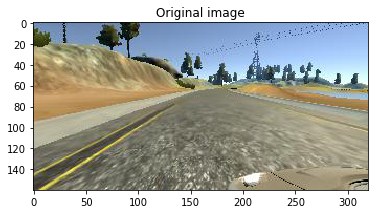

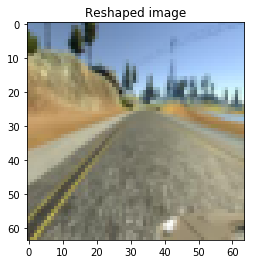

In [63]:
image = plt.imread(IMG_PATH + img_path)
plt.imshow(image)
plt.title('Original image')
plt.show()
image = resize(image)

plt.imshow(image.astype(np.uint8), cmap = 'gray')
plt.title('Reshaped image')
plt.show()

In [64]:
image = image.reshape(1, 64, 64, 3)
from keras import backend as K

def get_layer_output(layer_nb):
    return K.function([model.layers[0].input],[model.layers[layer_nb].output])

layer_output = get_layer_output(layer_nb = 1)([image])[0]
layer_2_output = get_layer_output(layer_nb = 4)([image])[0]

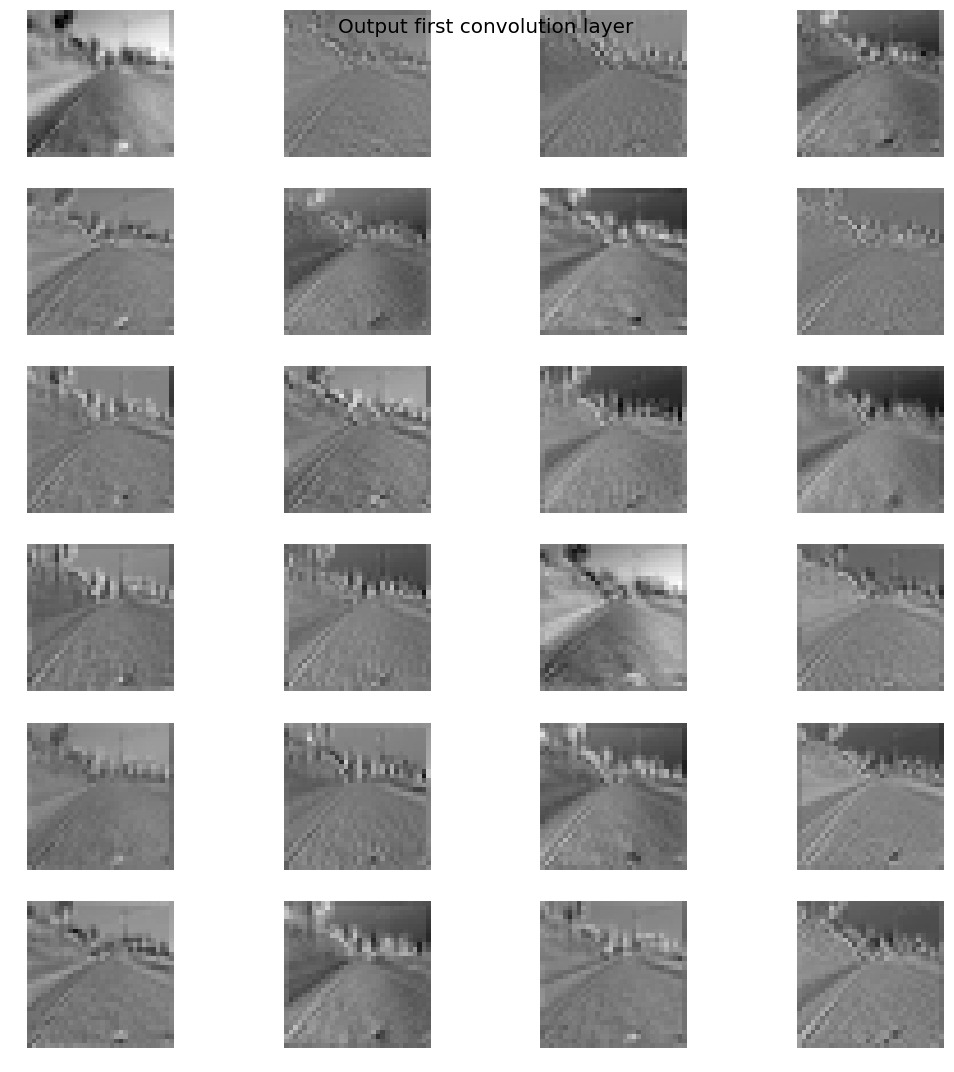

In [65]:
import matplotlib.cm as cm
fig, axes = plt.subplots(6, 4, figsize = (15,15))
vmin = layer_output.min()
vmax = layer_output.max()


for i, ax in enumerate(axes.flat):
    if i < 24:
        image = layer_output[:,:,:,i].reshape([32, 32]) 
        ax.imshow(image, vmin=vmin, vmax=vmax, interpolation='nearest', cmap=cm.binary)
        ax.axis('off')

fig.suptitle('Output first convolution layer', fontsize=20)

plt.axis('off')
plt.tight_layout()
plt.show()
fig.savefig('output.jpg')

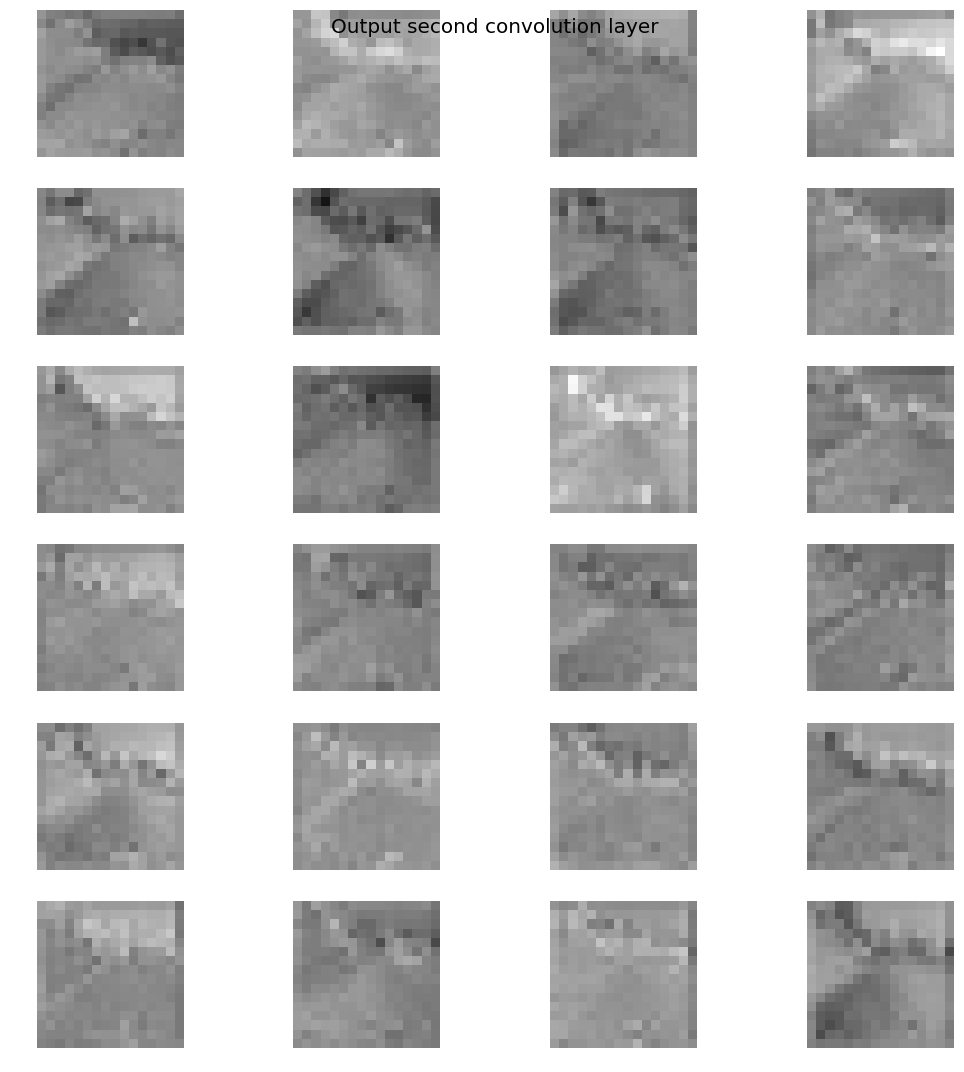

In [66]:
fig, axes = plt.subplots(6, 4, figsize = (15,15))
vmin = layer_2_output.min()
vmax = layer_2_output.max()

for i, ax in enumerate(axes.flat):
    if i < 24:
        image = layer_2_output[:,:,:,i].reshape([16,16]) 
        ax.imshow(image, vmin=vmin, vmax=vmax, interpolation='nearest', cmap=cm.binary)
        ax.axis('off')
        
fig.suptitle('Output second convolution layer', fontsize=20)
plt.axis('off')
plt.tight_layout()
plt.show()